# Modélisation 
### Nous allons effectuer sur ce notebook la partie modélisation en utilisant les features SANS PCA

In [10]:
import pandas as pd
# ^^^ pyforest auto-imports - don't write above this line
import pyforest
import os
import warnings
import sklearn
import time 
import pickle
import matplotlib.pyplot as plt
import seaborn as sns


#preparation des données
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

#modeles :
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier, LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier

#mesure performance : 
from sklearn import metrics
warnings.filterwarnings("ignore")

In [11]:
# Lecture des données :
path1 = [i for i in os.getcwd().split("\\")]
path1

['D:',
 'Etude_Data_science',
 'Kaggle_competition',
 '02_Binary_Prediction_of_Smoker_Status_using_Bio-Signals',
 'notebook']

In [12]:
path2 = ("\\").join(path1[:-1]) + "\\dataset"

In [13]:
os.listdir(path2)

['data_cleaned.csv',
 'data_cleaned_PCA.csv',
 'data_cleaned_withoutPCA.csv',
 'playground-series-s3e24.zip',
 'sample_submission.csv',
 'test.csv',
 'train.csv']

In [14]:
data = pd.read_csv(path2+"\\data_cleaned_withoutPCA.csv", index_col = 0)
df = data.copy()
df.head()

<IPython.core.display.Javascript object>

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),systolic,relaxation,fasting blood sugar,Cholesterol,...,hemoglobin,serum creatinine,AST,ALT,Gtp,hearing(left),hearing(right),Urine protein,dental caries,smoking
60700,-0.363764,-1.729695,-1.361653,-0.333247,-1.261648,-1.278404,-0.194342,0.127119,0.239934,-0.591152,...,-2.090771,-1.626365,-1.190789,-0.851755,-0.871202,1,1,1,0,0
44065,1.750195,-1.729695,-1.361653,-1.563035,-0.762843,-0.002432,1.298727,1.348476,9.462864,0.500179,...,1.052672,-1.626365,-0.880976,-0.139049,-0.358082,1,1,1,0,0
39538,0.904612,-1.162983,-0.963707,-0.333247,0.484171,0.507957,-1.058751,-0.650109,-0.610407,-1.471258,...,-0.973102,-1.626365,-0.674434,-0.632461,-0.646712,1,1,1,0,0
105427,0.904612,-0.596270,-0.565762,0.002149,-0.762843,-0.512820,0.591484,0.349184,-0.610407,1.204263,...,-0.134851,-1.071018,-1.190789,-0.742108,-0.326012,1,1,1,0,0
148669,-1.209348,1.670580,1.821910,1.343736,-0.014635,0.507957,-0.194342,0.571249,-0.741229,-1.154420,...,-0.693685,0.039675,-0.054807,0.189892,-0.486362,1,1,1,0,0


In [15]:
df.shape

(159256, 23)

#### Récupération d'un sample du dataframe pour effectuer les différents test de modélisation

##### La colonne sera ensuite mute une fois les tests terminés pour utiliser l'ensemble du dataframe
df = df.sample(1000, random_state=42)

In [16]:
df.shape

(159256, 23)

In [17]:
X,y = df.drop("smoking", axis = 1), df["smoking"]

In [18]:
X_train,X_test,y_train, y_test = train_test_split(X,y, random_state=42,
                                                 test_size=0.2)

# Plan : 

## 1. Création de fonction de modélisation et  Préparation des modèles

## 2. Entrainement des modèles

## 3. Résultats et premières selection de modèles

## 4. Visualisation des autres metrics

## 5. Amélioration des modèles par GridSearchCV

## 6. Visualisation des performances

# 1. Création des fonctions de modélisation et préparation des modèles

In [19]:
all_model = [DummyClassifier(),
             LogisticRegression(),
             KNeighborsClassifier(),
             SGDClassifier(),
             RandomForestClassifier()]

In [20]:
### Création d'une fonction d'entrainement pour un modèle donné

def train_model(model):
    """le modèle sera entrainé par validation score sur 5 split
    et affichage du score moyen.
    la fonction renvoi les prédiction du modèle entrainé et le temps d'entrainement"""
    scores = (cross_val_score(estimator=model, X=X_train,y=y_train, cv=5)).mean()
    print(str(model))
    print("Score moyen validation croisée :", scores.round(2))
    
    # Mesurer le temps de début
    start_time = time.time()
    
    #Entrainement du modele
    model.fit(X_train,y_train)
    
    # Mesurer le temps de fin
    end_time = time.time()
    
    # Calculer la durée totale
    training_time = round(end_time - start_time,2)
    #Convertir la duree en minute :
    training_time_min = round(training_time/60,2)

    yp = model.predict(X_test.values) #rajout ici '.values' pour que ca fonctionne avec KNN
    return yp,training_time_min, model

In [21]:
### Création d'une fonction qui renvoi l'ensemble des metrics :

def metric(prediction, model_name, exe_time):
    """Fonction qui renvoie un objet pandas Series contenant les valeurs des metrics
    principales : f1 score, accuracy, recall, precision score et le temps d'execution
    à partir de la liste des prédictions d'un modèle"""
    
    f1 = metrics.f1_score(y_true = y_test, y_pred = prediction)
    accuracy = metrics.accuracy_score(y_true = y_test, y_pred = prediction)
    recal = metrics.recall_score(y_true = y_test, y_pred = prediction)
    precision = metrics.precision_score(y_true = y_test, y_pred = prediction)
    
    all_metric = [f1,accuracy,recal,precision, exe_time]
    
    index_metric = ["F1","accuracy","recall","precision","duree_entrainement(min)"]
    
    series = pd.Series(all_metric, name=str(model_name), index=index_metric)
    return pd.DataFrame(series)
    
    

In [22]:
### fonction pour créer une matrice de confusion : 

def matrice_confusion(prediction):
    cf = metrics.confusion_matrix(y_true=y_test, y_pred=prediction)
    plt.figure(figsize=(4,4))
    ax = sns.heatmap(cf, annot = True, linewidths=0.8, linecolor="black", fmt = ".0f",cbar=False, cmap = "Blues")
    ax.set_xlabel('Prédictions')
    ax.set_ylabel('Valeurs réelles')
    plt.title("Confusion Matrix")
    plt.show()


In [23]:
### Fonction pour obtenir la learning curve d'un modèle : 
def learning_curv(model):
    train_sizes, train_scores, test_scores = learning_curve(model,
                                                                X_train, y_train, cv=5)
    
# Calcul des scores moyens pour l'apprentissage et la validation
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

# Tracer les courbes d'apprentissage
    plt.figure(figsize=(4, 3))
    plt.plot(train_sizes, train_scores_mean, label='Score d\'entraînement moyen')
    plt.plot(train_sizes, test_scores_mean, label='Score de validation moyen')
    plt.xlabel('Taille de l\'ensemble d\'entraînement')
    plt.ylabel('Score')
    plt.title('Courbes d\'apprentissage')
    plt.legend()
    plt.show()
    


In [61]:
### Fonction pour obtenir la courbe ROC : 

def ROC(prediction):
    FP_rate, TP_rate, thresholds = metrics.roc_curve(y_test,prediction)
    roc_auc = metrics.auc(FP_rate,TP_rate)
    print("ROC_AUC =", roc_auc.round(2))
    
    
    ### Création de la courbe AUC ROC :
    plt.figure(figsize=(4,4))
    
    #Courbe prédictive :
    sns.lineplot(x = FP_rate, y = TP_rate, color = "orange", label = f"AUC = {roc_auc:,.2f}%")
    
    #Courbe random :
    sns.lineplot(x=[0,1],y=[0,1], linestyle = "--", c = "r", label= "Random Classifier")

    plt.ylabel("True Positive rate")
    plt.xlabel("False Positive rate")
    plt.title("ROC")
    plt.legend(loc = "upper left")
    plt.show()

In [25]:
### Fonction permettant d'améliorer un modèle grâce au GridSearchCV :

def Grid(model, param):
    """Le modèle sera entrainé sur 5 splits
    et renverra les prédictions du meilleur modèles ainsi que son temps d'entrainement"""
    
 # Mesurer le temps de début
    start_time = time.time()
        
    #Entrainement du grid sur les paramètres
    grid = GridSearchCV(estimator=model, param_grid=param, cv=5)
    grid.fit(X_train, y_train)
    # Mesurer le temps de fin
    end_time = time.time()
    
    #Recuperation des meilleurs hyper parametres :
    best_model = grid.best_estimator_
    
    # Convertir X_test en un format compatible si nécessaire
    X_test_transformed = X_test.values  

    
    #Recuperation des predictions
    yp = best_model.predict(X_test_transformed)
    
    #Calcul temps d'execution:
    training_time = round(end_time- start_time  , 3)
    #On converti en minutes :
    training_time_min = round(training_time/60,2)
    
    return yp, training_time_min, best_model

## 2. Entrainement des différents modèles et récupération des metrics :
- Nous allons créer une boucle qui va parcourir notre liste des modèles utilisés et qui fera :
    - Entrainement des modèles et récupèrera les prédictions et les temps d'execution
    - Enregistrement du modèle sur le dictionnaire dict_model_trained
    - Ajout des metrics dans le dictionnaire dict_metric
    - ajout des prédiction dans le dictionnaire dict_prediction
    -  enregistrement final dans un dataframe contenant les différentes metrics

##### Chemin d'enregistrement des modèles entrainé sur les features non réduites par PCA :

In [45]:
save_path = r'D:\\Etude_Data_science\\Kaggle_competition\\02_Binary_Prediction_of_Smoker_Status_using_Bio-Signals\\Modeles_withoutPCA'

In [46]:
#Dictionnaire qui contiendra les différentes metrics de chaque modèle
dict_metric = {}

#dictionnaire contenant les valeurs prédictives pour chaque modèles
dict_prediction = {}

#dictionnaire contenant les modele entrainé
dict_model_trained = {}

for current_model in all_model:
    #Recuperation des prédictions et du temps d'execution de chaque modèles
    prediction, temps_exe, model_trained = train_model(current_model)
    
    
    # Récupération du nom du modèle et du chemin d'enregistrement
    model_name = current_model.__class__.__name__
    
    # Enregitrement des modèles après entrainement : 
    dict_model_trained[model_name] = model_trained
    
    
    
    #Enregistrement des prédiction dans le dictionnaire :
    dict_prediction[model_name] = prediction
    
    # Enregistrement des métriques au dictionnaire
    dict_metric[model_name] = metric(prediction=prediction, model_name=model_name, exe_time=temps_exe)

    
#Pour les Dataframe :
    
# Concaténation des métriques en un DataFrame
df_metrics = pd.concat(dict_metric.values(), axis=1)
#intervertissons les colonnes et les indexs :
df_metrics = df_metrics.T
# Enregistrement du DataFrame des métriques
df_metrics.to_csv("df_metrics_withoutPCA.csv")


#Enregistrement des prédictions dans un dataframe :
df_prediction = pd.DataFrame(dict_prediction)
# Enregistrement du DataFrame des prédictions
df_prediction.to_csv("df_prediction_withoutPCA.csv")


DummyClassifier()
Score moyen validation croisée : 0.56


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

LogisticRegression()
Score moyen validation croisée : 0.75


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

KNeighborsClassifier()
Score moyen validation croisée : nan


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

SGDClassifier()
Score moyen validation croisée : 0.75


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

RandomForestClassifier()
Score moyen validation croisée : 0.77


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [47]:
#Enregistrement des modèles :

for i in dict_model_trained:
    model_name = i
    current_model = dict_model_trained[model_name]
    model_filename = os.path.join(save_path, f"{model_name}.pkl")
    #Enregistrement des modèles préentrainé :
    with open(model_filename, 'wb') as model_file:
        pickle.dump(current_model, model_file)


### 3. Résultats et premières selection de modèles
- Nous allons déja effectuer un premier filtre de modèles en supprimant ceux qui mettent beaucoup trop de temps à s'entrainer

In [48]:
df_metrics.sort_values(by = "F1", ascending=False)

,F1,accuracy,recall,precision,duree_entrainement(min)
RandomForestClassifier,0.752986,0.770784,0.802481,0.709242,0.66
SGDClassifier,0.744754,0.753296,0.826711,0.677581,0.01
LogisticRegression,0.719560,0.748430,0.741328,0.699034,0.01
KNeighborsClassifier,0.699569,0.728808,0.725247,0.675647,0.00
DummyClassifier,0.000000,0.564643,0.000000,0.000000,0.00


#### Observation : 

- On peut voir que le **KRandomforestClassifierNN** est le modèle ayant le **meilleur F1 score**. Autrement dit on a le meilleur ratio **precision/recall** avec un temps d'execution de 0.67 min (<45s)
- ensuite nous avons le SGDC qui a un F1 très proche, on peut v oir que ce modèle a un meilleur recall que le randomforest mais une moins bonne accuracy, ce modèle peut être interessant si on veut detecter les faux positifs (prédit fumeur mais ne l'est pas en réalité

- L'ensemble des modèles ont pu s'entrainer lorsqu'on compare au dummyclassifier et donc ont reussi a apprendre

## Conclusion :

## 4. Visualisation des autres metrics : 

### matrice de confusion : 

DummyClassifier


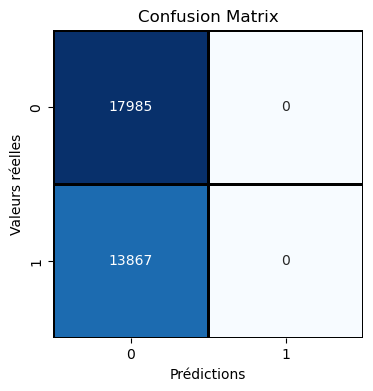

LogisticRegression


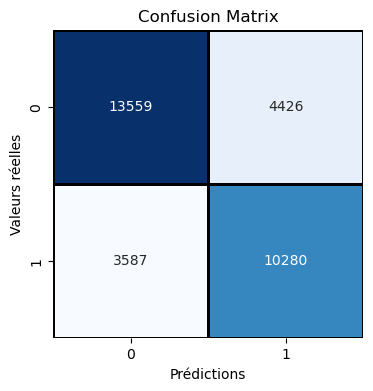

KNeighborsClassifier


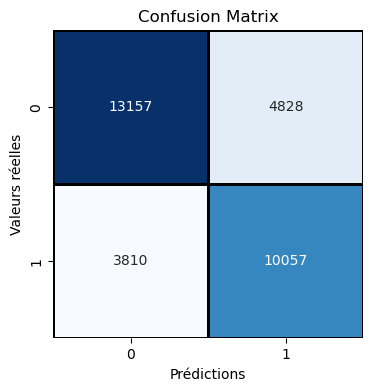

SGDClassifier


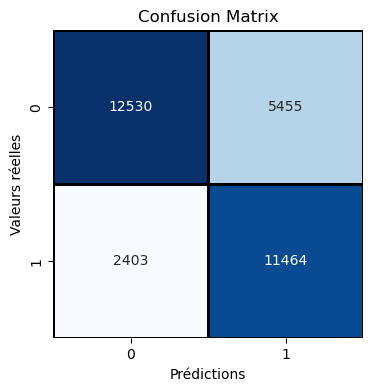

RandomForestClassifier


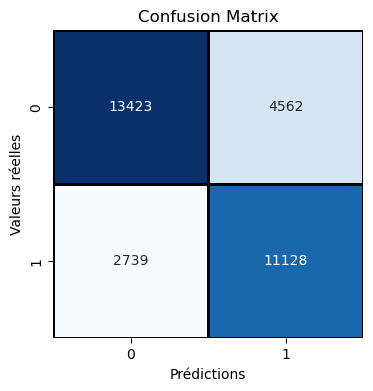

In [50]:
for i in df_prediction:
    print(i)
    matrice_confusion(df_prediction[i])
    

### ROC

DummyClassifier
ROC_AUC = 0.5


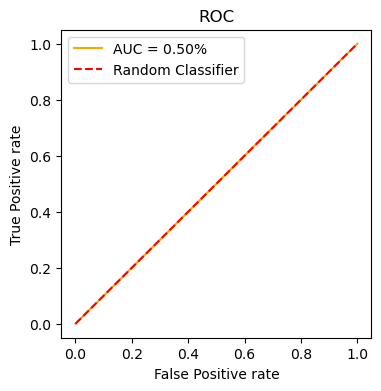

LogisticRegression
ROC_AUC = 0.75


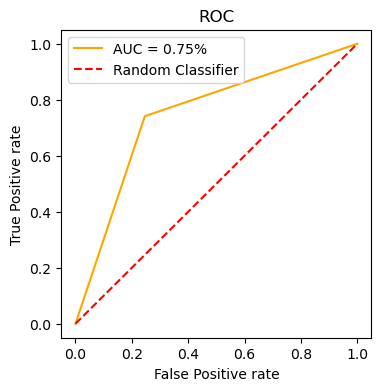

KNeighborsClassifier
ROC_AUC = 0.73


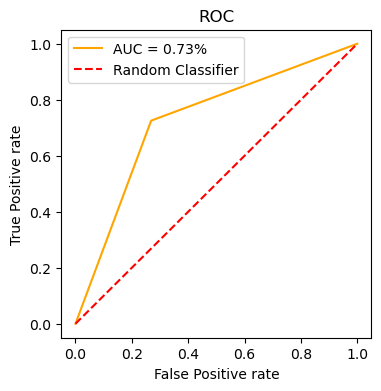

SGDClassifier
ROC_AUC = 0.76


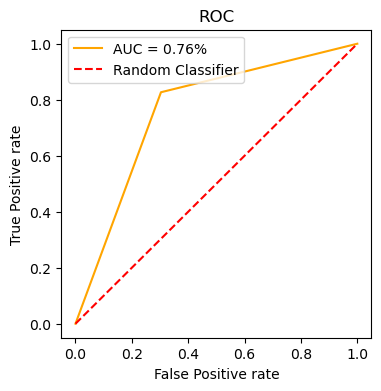

RandomForestClassifier
ROC_AUC = 0.77


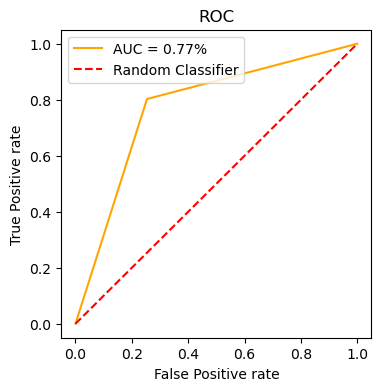

In [62]:
for i in df_prediction:
    print(i)
    ROC(df_prediction[i])

### Observation 
- l'air sous la courbe pour le randomforest est de 77%, suivi de très près par les autres modèles.

### 5. Amélioration des modèles par Grid
- 

In [69]:
param_grid_LR = { "penalty" : ['l1', 'l2', 'elasticnet']} 

param_grid_knn = {"n_neighbors":np.arange(2,10),
              "metric":["manhattan","euclidean"]
             }
param_grid_SGD = {"loss" : ['hinge', 'log_loss',"squared_error"], "alpha":np.linspace(0,1,5), 
                 "epsilon":np.linspace(0.1,1,4)}
param_grid_forest = {"n_estimators":[100,1000,5000] }

dict_param_grid = [param_grid_knn, param_grid_LR, param_grid_SGD]


In [70]:
models_and_params = [(LogisticRegression(), param_grid_LR), (KNeighborsClassifier(), param_grid_knn), 
                     (SGDClassifier(), param_grid_SGD), (RandomForestClassifier(), param_grid_forest)
                    ]

#### Recuperation des prédictions et des temps d'execution pour chaque modèles par GRID : 

In [71]:
df_prediction_GRID = pd.DataFrame()
df_time_GRID = pd.DataFrame()
dict_best_estimators = {}
for model, param, in models_and_params:
    prediction, time_execution,best_mod = Grid(model=model,param= param)
    # Récupération du nom du modèle
    model_name = model.__class__.__name__    
    
    #Ajout des prédiction dans le dataframe 
    df_prediction_GRID[model_name] = prediction
    #Ajout des temps d'execution dans le dataframe du temps d'execution
    df_time_GRID[model_name] = pd.Series(time_execution) #mettre en Series pour que la valeur soit acceptée
    
     #ajout du meilleur estimateur dans le dictionnaire : 
    dict_best_estimators[model_name] = best_mod
    

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [72]:
# Récupération du nom du modèle et du chemin d'enregistrement
save_path_grid = r"D:\Etude_Data_science\Kaggle_competition\02_Binary_Prediction_of_Smoker_Status_using_Bio-Signals\Modeles_withoutPCA\Grid"
for i in dict_best_estimators:
    model_name = i
    current_model = dict_best_estimators[model_name]
    model_filename = os.path.join(save_path_grid, f"{model_name}.pkl")
    
    #Enregistrement des modèles préentrainé :
    with open(model_filename, 'wb') as model_file:
        pickle.dump(current_model, model_file)


#### Calcul des différentes metric par GRID

In [73]:
dict_metric_GRID = {}
for prediction,temps in zip(df_prediction_GRID, df_time_GRID):
    nom_model = prediction
    dict_metric_GRID[nom_model] = metric(prediction=df_prediction_GRID[prediction].values,
                                         model_name=prediction, 
                                         exe_time=df_time_GRID[temps].values[0])#permet d'obtenir la valeur 
    #qui ne sera pas une liste


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [74]:
# Concaténation des métriques en un DataFrame
df_metrics_GRID = pd.concat(dict_metric_GRID.values(), axis=1)
#intervertissons les colonnes et les indexs :
df_metrics_GRID = df_metrics_GRID.T


<IPython.core.display.Javascript object>

In [75]:
df_metrics_GRID.sort_values(by="F1", ascending = False)

,F1,accuracy,recall,precision,duree_entrainement(min)
RandomForestClassifier,0.760467,0.775305,0.819283,0.709530,195.99
SGDClassifier,0.738981,0.743062,0.835437,0.662492,6.34
LogisticRegression,0.719560,0.748430,0.741328,0.699034,0.04
KNeighborsClassifier,0.545814,0.675531,0.447826,0.698695,0.04


### le modèle RandomforestClassifier est très long en entrainement pour des metrics pas significativement supérieur au randomforest par défaut

**195min sois 3h d'entrainement pour gagner un tout petit peu de précision ne vaut pas le coup pour le RandomForestClassifier**

LogisticRegression
ROC_AUC = 0.75


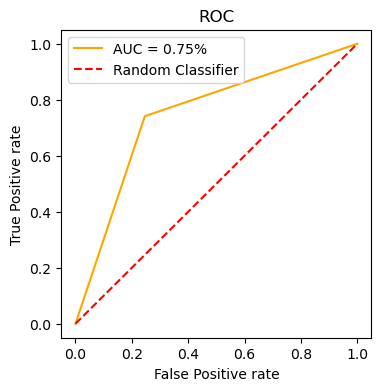

KNeighborsClassifier
ROC_AUC = 0.65


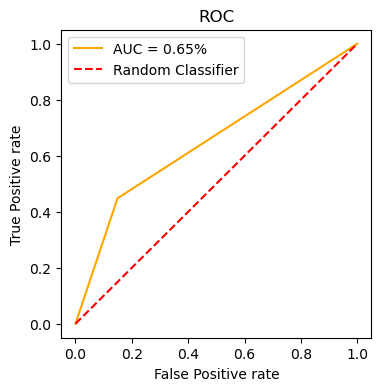

SGDClassifier
ROC_AUC = 0.75


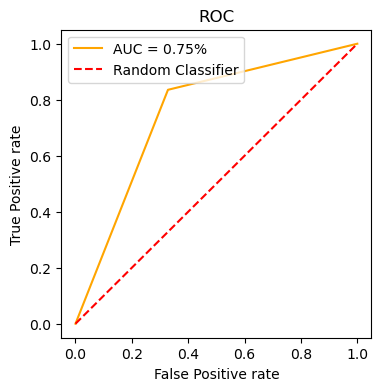

RandomForestClassifier
ROC_AUC = 0.78


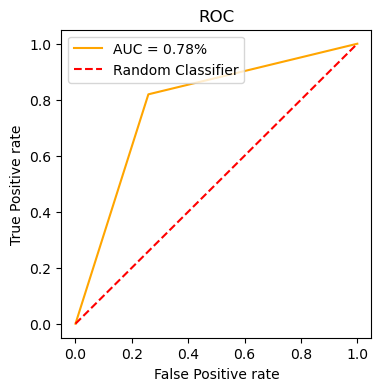

In [82]:
for i in df_prediction_GRID:
    print(i)
    ROC(df_prediction_GRID[i])

LogisticRegression


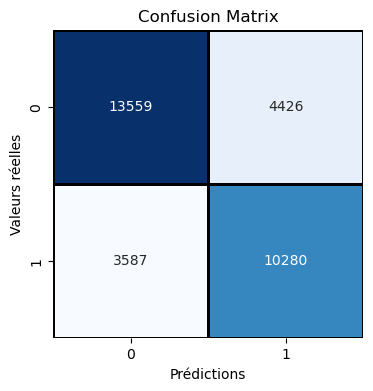

KNeighborsClassifier


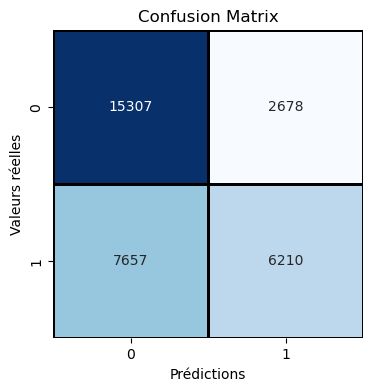

SGDClassifier


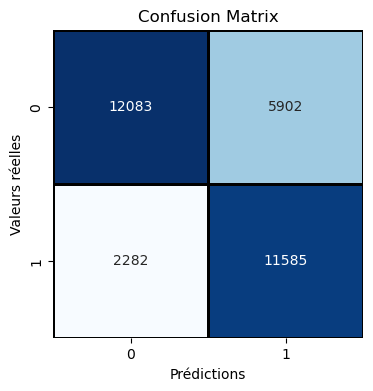

RandomForestClassifier


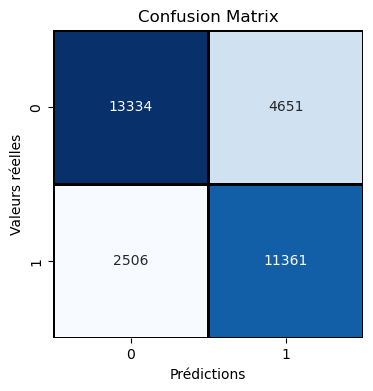

In [76]:
for i in df_prediction_GRID:
    print(i)
    matrice_confusion(df_prediction_GRID[i])

## Conclusion final :
- Le modèle le plus adapté ici que nous allons conserver est  le **RandomforestClassifier** par défaut.

## Pour la soumission du projet sur kaggle :
- Kaggle attend à ce qu'on renvoie un fichier contenant pour chaque fumeur (id) la probabilité de la target
- Lorsque nous chargerons notre modèle dans le notebook numéro 4 soumission_modele, nous utiliserons la fonction "predict_proba" afin d'effectuer les prédictions de chaque patients